In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
import functools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchinfo

import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm
from torchvision.utils import make_grid

import helper

%load_ext autoreload
%autoreload 2

DATASET_PATH = "/home/excellent/Documents/ds/datasets/anime_faces/images"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def show_files_stats():
    filenames = next(os.walk(DATASET_PATH), (None, None, []))[2]
    print(f"Total images: {len(filenames)}")
    filenames.sort()

    shapes = Counter()
    for filename in filenames:
        img = cv2.imread(os.path.join(DATASET_PATH, filename), cv2.IMREAD_ANYCOLOR)
        shapes[img.shape] += 1

    for shape, cnt in list(sorted(shapes.items(), key=lambda kvp: -kvp[1]))[:50]:
        print(f"Shape {shape}, count {cnt}")

show_files_stats()

Total images: 63565
Shape (92, 92, 3), count 1636
Shape (96, 96, 3), count 1556
Shape (94, 94, 3), count 1534
Shape (95, 95, 3), count 1530
Shape (90, 90, 3), count 1516
Shape (98, 98, 3), count 1500
Shape (91, 91, 3), count 1447
Shape (99, 99, 3), count 1439
Shape (93, 93, 3), count 1434
Shape (97, 97, 3), count 1406
Shape (100, 100, 3), count 1394
Shape (89, 89, 3), count 1360
Shape (88, 88, 3), count 1337
Shape (101, 101, 3), count 1285
Shape (102, 102, 3), count 1276
Shape (85, 85, 3), count 1272
Shape (87, 87, 3), count 1264
Shape (86, 86, 3), count 1262
Shape (84, 84, 3), count 1245
Shape (103, 103, 3), count 1235
Shape (104, 104, 3), count 1200
Shape (82, 82, 3), count 1085
Shape (83, 83, 3), count 1028
Shape (81, 81, 3), count 1020
Shape (105, 105, 3), count 1011
Shape (106, 106, 3), count 946
Shape (76, 76, 3), count 942
Shape (79, 79, 3), count 934
Shape (80, 80, 3), count 923
Shape (77, 77, 3), count 869
Shape (78, 78, 3), count 853
Shape (108, 108, 3), count 825
Shape (107,

In [2]:
def load_anime_faces_dataset(n_images):
    CHANNELS = 3
    NEW_SHAPE = (64, 64)
    DTYPE = np.float32

    filenames = next(os.walk(DATASET_PATH), (None, None, []))[2]
    filenames.sort()

    dataset = []

    means = np.zeros(CHANNELS, dtype=DTYPE)
    stds = np.zeros(CHANNELS, dtype=DTYPE)

    for filename in filenames:
        if n_images is not None and len(dataset) >= n_images:
            break

        img = cv2.imread(os.path.join(DATASET_PATH, filename), cv2.IMREAD_ANYCOLOR)
        shape = img.shape
        if shape[0] <= 60 or shape[1] <= 60:
            continue
        img = cv2.resize(img, NEW_SHAPE, cv2.INTER_LANCZOS4)
        img = img.astype(DTYPE)

        for ch in range(CHANNELS):
            means[ch] += img[:, :, ch].sum()
            stds[ch] += img[:, :, ch].std() * np.prod(NEW_SHAPE)

        dataset.append(img)

    coeff = len(dataset) * np.prod(NEW_SHAPE)
    means /= coeff
    stds /= coeff

    for i in range(len(dataset)):
        img = dataset[i]
        img = (img - means) / stds
        img = np.moveaxis(img, -1, 0)
        dataset[i] = img

    coeff = len(dataset) * np.prod(NEW_SHAPE)
    return dataset, means, stds

dataset, dataset_means, dataset_stds = load_anime_faces_dataset(n_images=None)
print(f"Dataset length {len(dataset)}, image shape {dataset[0].shape}")
print(f"Dataset means: {dataset_means}")
print(f"Dataset stds: {dataset_stds}")
print(f"Dataset dtype: {dataset[0].dtype}")

Dataset length 58952, image shape (3, 64, 64)
Dataset means: [146.22772 150.0884  175.43535]
Dataset stds: [59.856873 65.64922  62.718517]
Dataset dtype: float32


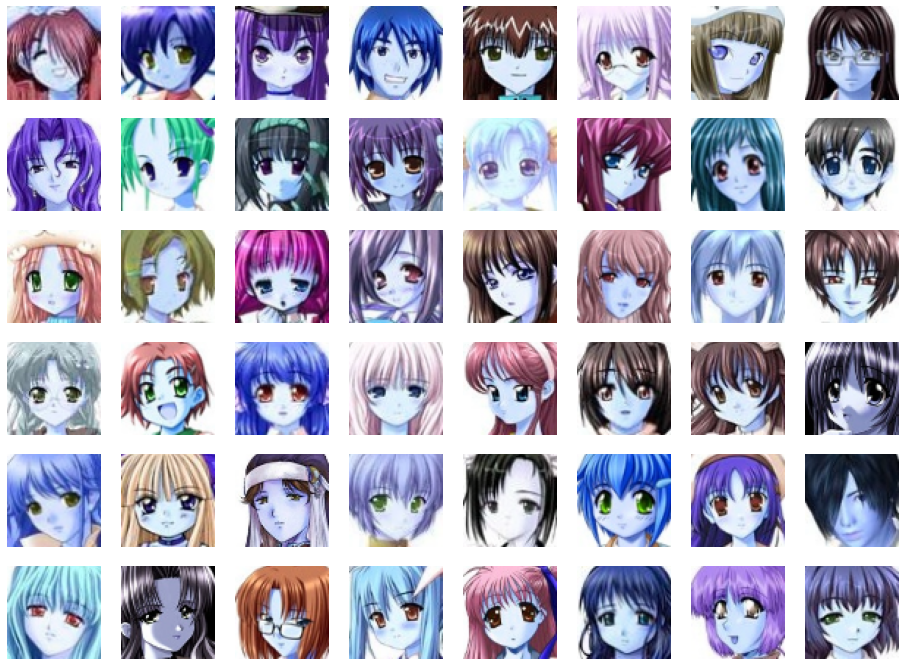

In [3]:
def show_images(n_rows, n_cols):
    plt.figure(figsize=(16, 12))

    for img_idx in range(min(len(dataset), n_rows * n_cols)):
        img = dataset[img_idx]
        img = np.moveaxis(img, 0, -1)
        img = img * dataset_stds + dataset_means
        img = img.astype(np.uint8)

        plt.subplot(n_rows, n_cols, img_idx + 1)
        plt.axis('off')
        plt.imshow(img)

show_images(n_rows=6, n_cols=8)

In [5]:
device = 'cuda'
# device = 'cpu'

def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

sigma = 25.0  #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [22]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


# Model1: channels=[32, 64, 128, 256], embed_dim=256, trainable params 1,790,819
class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[96, 192, 256, 384], embed_dim=256):
        super().__init__()

        IMAGE_CHANNELS = 3

        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
              nn.Linear(embed_dim, embed_dim))

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(IMAGE_CHANNELS, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 4, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 4, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 4, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 4, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 4, stride=2, bias=False, output_padding=0)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 4, stride=2, bias=False, output_padding=0)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], IMAGE_CHANNELS, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))
        # Encoding path
        h1 = self.conv1(x)
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [23]:
def test():
    score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
    print(torchinfo.summary(score_model, input_size=[(11, 3, 64, 64), (11,)]))
    # print(torchinfo.summary(score_model, input_size=[(11, 1, 28, 28), (11,)]))        # For MNIST

test()

Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [11, 3, 64, 64]           --
├─ScoreNet: 1-1                                    [11, 3, 64, 64]           --
│    └─Sequential: 2-1                             [11, 256]                 --
│    │    └─GaussianFourierProjection: 3-1         [11, 256]                 (128)
│    │    └─Linear: 3-2                            [11, 256]                 65,792
│    └─Conv2d: 2-2                                 [11, 96, 62, 62]          2,592
│    └─Dense: 2-3                                  [11, 96, 1, 1]            --
│    │    └─Linear: 3-3                            [11, 96]                  24,672
│    └─GroupNorm: 2-4                              [11, 96, 62, 62]          192
│    └─Conv2d: 2-5                                 [11, 192, 30, 30]         294,912
│    └─Dense: 2-6                                  [11, 192, 1, 1]           --
│    │    └─Lin

/tmp/ipykernel_5400/2496108765.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [9]:
#@title Training (double click to expand or collapse)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 200
batch_size = 32
lr = 1e-4

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
for epoch in tqdm.notebook.tqdm(range(n_epochs)):
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # tqdm_epoch.set_description(f"Epoch {epoch} / {n_epochs - 1} Average Loss: {avg_loss / num_items}")
    print(f"Epoch {epoch} / {n_epochs - 1} Average Loss: {avg_loss / num_items}")
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), f"anime_faces_modelB_{epoch}.pth")

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_3972/3968223702.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Epoch 0 / 199 Average Loss: 4325.49764277903
Epoch 1 / 199 Average Loss: 1608.3463001745595
Epoch 2 / 199 Average Loss: 1314.8600242636487
Epoch 3 / 199 Average Loss: 1185.3386962161749
Epoch 4 / 199 Average Loss: 1072.9716293287336
Epoch 5 / 199 Average Loss: 999.3426363258191
Epoch 6 / 199 Average Loss: 940.7095887795897
Epoch 7 / 199 Average Loss: 908.5029899192351
Epoch 8 / 199 Average Loss: 883.7153864402528
Epoch 9 / 199 Average Loss: 864.5701549714837
Epoch 10 / 199 Average Loss: 848.1253856918287
Epoch 11 / 199 Average Loss: 829.448002105394
Epoch 12 / 199 Average Loss: 821.5106192226568
Epoch 13 / 199 Average Loss: 810.9281751467296
Epoch 14 / 199 Average Loss: 801.6801489287631
Epoch 15 / 199 Average Loss: 791.6621653328662
Epoch 16 / 199 Average Loss: 784.396564951097
Epoch 17 / 199 Average Loss: 778.2488848183692
Epoch 18 / 199 Average Loss: 768.0516448862793
Epoch 19 / 199 Average Loss: 772.2363242652656
Epoch 20 / 199 Average Loss: 760.7335165983819
Epoch 21 / 199 Average

In [8]:
def test():
    ckpt = torch.load('anime_faces_modelB_199.pth', map_location=device)
    for k, v in ckpt.items():
        print(k, v.__class__)

test()

module.embed.0.W <class 'torch.Tensor'>
module.embed.1.weight <class 'torch.Tensor'>
module.embed.1.bias <class 'torch.Tensor'>
module.conv1.weight <class 'torch.Tensor'>
module.dense1.dense.weight <class 'torch.Tensor'>
module.dense1.dense.bias <class 'torch.Tensor'>
module.gnorm1.weight <class 'torch.Tensor'>
module.gnorm1.bias <class 'torch.Tensor'>
module.conv2.weight <class 'torch.Tensor'>
module.dense2.dense.weight <class 'torch.Tensor'>
module.dense2.dense.bias <class 'torch.Tensor'>
module.gnorm2.weight <class 'torch.Tensor'>
module.gnorm2.bias <class 'torch.Tensor'>
module.conv3.weight <class 'torch.Tensor'>
module.dense3.dense.weight <class 'torch.Tensor'>
module.dense3.dense.bias <class 'torch.Tensor'>
module.gnorm3.weight <class 'torch.Tensor'>
module.gnorm3.bias <class 'torch.Tensor'>
module.conv4.weight <class 'torch.Tensor'>
module.dense4.dense.weight <class 'torch.Tensor'>
module.dense4.dense.bias <class 'torch.Tensor'>
module.gnorm4.weight <class 'torch.Tensor'>
module

Loaded checkpoint: anime_faces_modelB_190.pth
Loaded checkpoint: anime_faces_modelB_191.pth
Loaded checkpoint: anime_faces_modelB_192.pth
Loaded checkpoint: anime_faces_modelB_193.pth
Loaded checkpoint: anime_faces_modelB_194.pth
Loaded checkpoint: anime_faces_modelB_195.pth
Loaded checkpoint: anime_faces_modelB_196.pth
Loaded checkpoint: anime_faces_modelB_197.pth
Loaded checkpoint: anime_faces_modelB_198.pth
Loaded checkpoint: anime_faces_modelB_199.pth


/tmp/ipykernel_5400/2496108765.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_5400/2496108765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


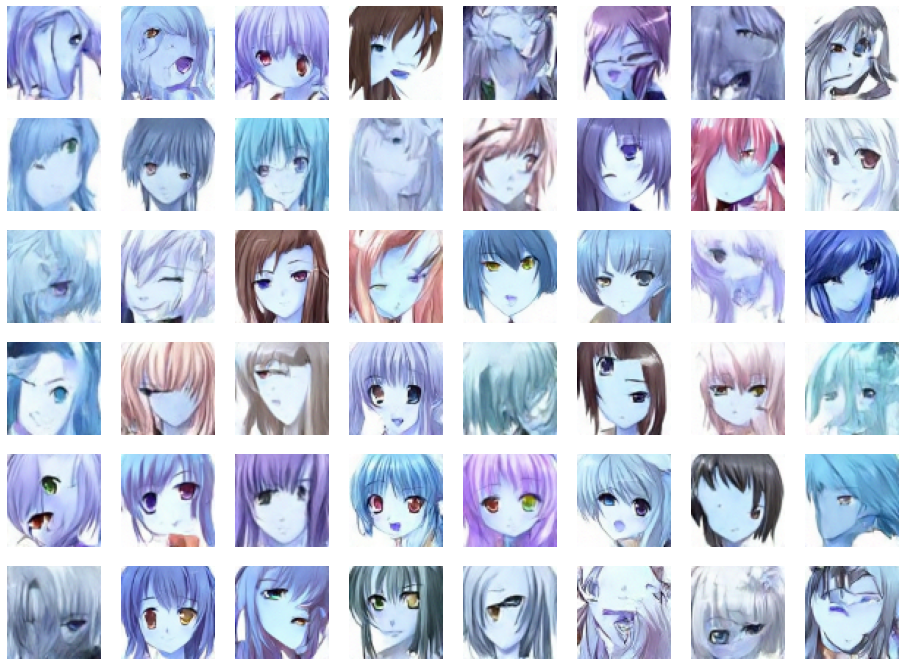

In [11]:
def _merge_checkpoints(prev, curr, factor):
    for module_name in list(curr):
        new_tensor = curr[module_name] * factor + prev[module_name] * (1 - factor)
        curr[module_name] = new_tensor
    return curr

def generate(n_rows=6, n_cols=8):
    device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
    score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

    ckpt = None
    for epoch in range(190, 200):
        checkpoint_name = f"anime_faces_modelB_{epoch}.pth"
        new_ckpt = torch.load(checkpoint_name, map_location=device)
        if ckpt is None:
            ckpt = new_ckpt
        else:
            ckpt = _merge_checkpoints(ckpt, new_ckpt, factor=0.5)
        print("Loaded checkpoint:", checkpoint_name)

    score_model.load_state_dict(ckpt)

    sample_batch_size = n_rows * n_cols
    # sampler = helper.Euler_Maruyama_sampler
    sampler = helper.pc_sampler
    # sampler = helper.ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

    ## Generate samples using the specified sampler.
    samples = sampler(score_model=score_model,
                    marginal_prob_std=marginal_prob_std_fn,
                    diffusion_coeff=diffusion_coeff_fn,
                    batch_size=sample_batch_size,
                    img_shape=(3, 64, 64),
                    device=device)

    samples = samples.cpu().detach().numpy()

    plt.figure(figsize=(16, 12))

    for img_idx in range(samples.shape[0]):
        img = samples[img_idx, ...]
        img = np.moveaxis(img, 0, -1)
        img = img * dataset_stds + dataset_means
        img = img.clip(0, 255)
        img = img.astype(np.uint8)

        plt.subplot(n_rows, n_cols, img_idx + 1)
        plt.axis('off')
        plt.imshow(img)

    plt.savefig('generated.png')

generate(n_rows=6, n_cols=8)